# Clustering

In this task we'll use clustering to explore and determine cohorts/segments of car adverts.

**Clustering from the business perspective of Mobile.de/Craigslist:**

Sites like Craigslist and Mobile.de have a very large user base, with a constant flow of new car offers. Since it is impossible to analyize each individual site user or car offer, these companies need to find similarity between these users and abstract them to cohorts and groups. By knowing which cluster a data point is ascribed to, we can make generalized assumptions about this data point and take targeted measures for this specific user based on his cohort. In the case of mobile.de one could identify a user group with a specific taste in cars and assign them to offers that match their preferences.

**Clustering in the technical sense:**

Clustering falls under unsupervised learning. This means that, unlike regression and classification, clustering doesn't have a label that needs to be predicted. Subject of clustering is not the label, but the distance between data points in the distribution. Clustering assumes that data points in a vector space that are close to each other are very similar. A bunch of similar vector points are called a cluster. One important aspect of clustering is, that these clusters aren't labeled. It's the data scientists job to interpret these clusters and name them accordingly. He or she needs to extract generalizations specific to this cluster. This information can then be used by marketing teams for example to design a targeted marketing campaign, based on the characteristics of this cluster of users.

## Agenda
- feature selection
- visual inspection with t-sne
- use different clustering algorithms
- conclusion

# Setup

In [ ]:
from google.colab import drive
import os

# skip, if not running on Google Colab
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


In [ ]:
# import modules and set options
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors

import plotly.express as px
import plotly.io as pio
from plotly.offline import iplot
import plotly.graph_objs as go

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering

pd.options.display.max_rows = 100 #default = 60
sns.set_theme(style="whitegrid")
pio.renderers.default = 'colab'

In [ ]:
# load pickle dataset into DataFrame
df = pd.read_pickle('df_std_no_outlier')
df_num = df.select_dtypes(include=np.number)

# Visual inspection

## t-SNE

In order to have a grasp of our data, we need to encode our multi-dimensional datset into 3D/2D vector space. This can be done with methods like PCA and t-SNE. Both translate our dataset into lower dimensions, while retaining information of distances between data points. This enables us to interpret our dataset visually.

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a complex algorithm that strives to retain information of neighboring data points for every given data point, hence 'Neighbor embedding'.

T-SNE tends to work better than PCA in most cases, but at the same time it is computationally much more expensive. (The reason why we just select a subset of our data to calculate)

In [ ]:
# t-SNE function
def t_sne(df, components=3, rnd_state=3, r_seed=3, n_samples=2000):
  embedded_array = TSNE(n_components=components, learning_rate='auto', init='random', random_state=rnd_state).fit_transform(df.select_dtypes(include=np.number).sample(n=n_samples, random_state=r_seed))
  
  return embedded_array

In [ ]:
# Augment our embedded DF with features from our normal DF

def merge_df(embedded_array, augment_df, n=2000, r_seed=3):
  
  #convert np array to df
  if embedded_array.shape[1] == 3:
    embedded_df = pd.DataFrame({'x':embedded_array[:,0], 'y':embedded_array[:,1], 'z':embedded_array[:,2]})
  elif embedded_array.shape[1] == 2:
    embedded_df = pd.DataFrame({'x':embedded_array[:,0], 'y':embedded_array[:,1]})
  else:
    print('has to be 2D or 3D')

  # extract right sample from augment df to add to t-sne array
  df_sample = augment_df.sample(n=n, random_state=r_seed).reset_index()
  
  # join both dfs
  augmented_df = embedded_df.join(df_sample)
  return augmented_df

In [ ]:
# create feature embedded array
embedded_array = t_sne(df)

# convert to df
augmented_df = merge_df(embedded_array=embedded_array, augment_df=df)
augmented_df

,x,y,z,index,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,0.883973,6.869830,10.571446,4698,montgomery,-0.495659,-1.125,ram,1500,-1.0,0.5,gas,0.747206,clean,automatic,rwd,0.0,pickup,blue,al,-0.955776,0.014837
1,-3.577944,5.462449,16.626656,280413,syracuse,-0.040926,-0.500,dodge,grand caravan,-1.0,0.0,gas,-0.385445,clean,automatic,fwd,0.0,mini-van,blue,ny,0.501900,0.420656
2,-5.110158,0.611378,-5.018093,107031,orlando,0.247623,0.250,acura,tsx,1.0,-0.5,gas,-0.052401,clean,automatic,fwd,0.0,sedan,grey,fl,-1.472144,0.218258
3,8.367016,-5.833988,0.130064,77715,denver,-0.412981,-0.750,chrysler,pt cruiser touring,0.0,-0.5,gas,0.312645,clean,automatic,fwd,-2.0,convertible,custom,co,0.047379,-0.744410
4,5.005100,5.800721,12.699526,153361,indianapolis,-0.512195,-0.750,dodge,sprinter 2500,-2.0,-0.5,diesel,1.263163,clean,automatic,rwd,0.0,van,white,in,0.085011,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-10.269547,2.422519,-0.824659,230942,asheville,0.909467,0.500,honda,pilot 4wd v6 touring,0.0,0.0,gas,0.064709,clean,automatic,4wd,0.0,SUV,white,nc,-0.566111,0.131602
1996,-1.017092,3.332925,14.919740,214699,minneapolis / st paul,-0.413394,-0.750,hyundai,tucson,-1.0,0.0,gas,0.164364,clean,automatic,fwd,0.0,SUV,black,mn,0.819431,-0.257661
1997,1.218441,10.178411,2.334753,140000,chicago,0.496486,-1.375,ford,f250 super duty,0.0,1.0,gas,-0.573115,clean,automatic,4wd,0.0,pickup,red,il,0.357187,-0.061423
1998,5.203397,-2.421438,-11.082944,351296,sioux falls / SE SD,-0.040926,-0.375,toyota,prius hybrid,0.0,-0.5,gas,-0.397966,clean,automatic,fwd,-1.0,hatchback,silver,sd,0.581043,-0.411706


## Plotly

Plotly is an interactive visualization package in Python. Besides having a variety of visualization methods, it allows us to dynamically toggle features, and move around a 3 dimensional plot, which makes data exploration easier and more engaging.

We'll use a 3D Scatter plot to get a first look at potential clusters. This give us for example an estimation for our k value in our clustering algorithm.

In [ ]:
fig = px.scatter_3d(augmented_df, x='x', y='y', z='z', color='state') # <-- select features for color coding
fig.show()

By color coding this plot by the features we used to generate this 3D model we can see how these variables embedded by the t-SNE algorithm.

For example color coding **condition** we can clearly see some sort of segmentation. Cars with worse condition seem to cluster on the right end of the x axis.

It's interesting to see how non-embedded features (e.g. state, type) reflect on the visualization:

**Observations:**

t-SNE with all numerical features:
- when color coding **states**: Alaska & Hawaii have clusters on the outer edges of this plot. The reason could be that the longitude and latitude are encoded in this lower dimension dataset, which in return translats in its distance to to other states. We could later remove long & lat to exclude geographical information in our data cloud and see the impact it had.
- When color coding **title_status** we can see a soft segmentation along the x-axis with status 'salvage' and 'rebuilt'
- When color coding **type** and filtering only for 'pickup' and 'hatchback', we can see a clear segmentation along the z-axis. (We could try to train a SVM on the classification task)
- When color coding **fuel** and de-select gas we can see a separation along the z-axis for 'hybrid' & 'electric' cars and 'diesel' cars.

## Additional experimentation

In this segment we try some unstructured, ad-hoc analysis. For example we going to remove our 'long' & 'lat' features to see how they impacted our feature embedding result, as well as see if our Hawaii and Alaska clusters still remain. 

We'll also try out embedding in 2D space. This could make it easier to compare different color codings with each other and extract useful information

### No geographical embedding

In [ ]:
# remove geographical features
df_no_geo = df.drop(columns=['long', 'lat'])

# create feature embedded array
embedded_array_no_geo = t_sne(df_no_geo)

# convert to df
augmented_no_geo = merge_df(embedded_array=embedded_array_no_geo, augment_df=df)
augmented_no_geo

,x,y,z,index,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,-2.911174,8.594933,5.838858,4698,montgomery,-0.495659,-1.125,ram,1500,-1.0,0.5,gas,0.747206,clean,automatic,rwd,0.0,pickup,blue,al,-0.955776,0.014837
1,-6.254916,7.287445,1.784037,280413,syracuse,-0.040926,-0.500,dodge,grand caravan,-1.0,0.0,gas,-0.385445,clean,automatic,fwd,0.0,mini-van,blue,ny,0.501900,0.420656
2,-3.355949,-12.300963,-9.036799,107031,orlando,0.247623,0.250,acura,tsx,1.0,-0.5,gas,-0.052401,clean,automatic,fwd,0.0,sedan,grey,fl,-1.472144,0.218258
3,12.874557,-0.411879,0.491515,77715,denver,-0.412981,-0.750,chrysler,pt cruiser touring,0.0,-0.5,gas,0.312645,clean,automatic,fwd,-2.0,convertible,custom,co,0.047379,-0.744410
4,0.865182,8.572707,11.540343,153361,indianapolis,-0.512195,-0.750,dodge,sprinter 2500,-2.0,-0.5,diesel,1.263163,clean,automatic,rwd,0.0,van,white,in,0.085011,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-7.619680,-4.752697,-3.405422,230942,asheville,0.909467,0.500,honda,pilot 4wd v6 touring,0.0,0.0,gas,0.064709,clean,automatic,4wd,0.0,SUV,white,nc,-0.566111,0.131602
1996,-6.334229,7.597624,4.102277,214699,minneapolis / st paul,-0.413394,-0.750,hyundai,tucson,-1.0,0.0,gas,0.164364,clean,automatic,fwd,0.0,SUV,black,mn,0.819431,-0.257661
1997,-3.155961,-1.725897,2.851230,140000,chicago,0.496486,-1.375,ford,f250 super duty,0.0,1.0,gas,-0.573115,clean,automatic,4wd,0.0,pickup,red,il,0.357187,-0.061423
1998,7.230217,-5.230171,1.839342,351296,sioux falls / SE SD,-0.040926,-0.375,toyota,prius hybrid,0.0,-0.5,gas,-0.397966,clean,automatic,fwd,-1.0,hatchback,silver,sd,0.581043,-0.411706


In [ ]:
fig = px.scatter_3d(augmented_no_geo, x='x', y='y', z='z', color='state') # <-- select features for color coding
fig.show()

Geographical information have been removed, and thus also our state clusters have vanished. With feature embedding it's important to keep in mind which features have been used and what their relationship to a cluster is.

When color coding by 'type' we still remain our softboundary for 'pickup' and 'hatchback'

It's also interesting how the shape of our data cloud changed. It now has this spiral-like shape.

### Embedding on 2D space

In [ ]:
# create feature embedded array
embedded_array_2d = t_sne(df, components=2)

# convert to df
augmented_2d = merge_df(embedded_array=embedded_array_2d, augment_df=df)
augmented_2d

,x,y,index,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,31.323830,2.877967,4698,montgomery,-0.495659,-1.125,ram,1500,-1.0,0.5,gas,0.747206,clean,automatic,rwd,0.0,pickup,blue,al,-0.955776,0.014837
1,45.836895,11.403642,280413,syracuse,-0.040926,-0.500,dodge,grand caravan,-1.0,0.0,gas,-0.385445,clean,automatic,fwd,0.0,mini-van,blue,ny,0.501900,0.420656
2,-7.983423,12.218660,107031,orlando,0.247623,0.250,acura,tsx,1.0,-0.5,gas,-0.052401,clean,automatic,fwd,0.0,sedan,grey,fl,-1.472144,0.218258
3,-2.193520,-24.945107,77715,denver,-0.412981,-0.750,chrysler,pt cruiser touring,0.0,-0.5,gas,0.312645,clean,automatic,fwd,-2.0,convertible,custom,co,0.047379,-0.744410
4,41.648724,-10.301821,153361,indianapolis,-0.512195,-0.750,dodge,sprinter 2500,-2.0,-0.5,diesel,1.263163,clean,automatic,rwd,0.0,van,white,in,0.085011,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-4.577811,27.786692,230942,asheville,0.909467,0.500,honda,pilot 4wd v6 touring,0.0,0.0,gas,0.064709,clean,automatic,4wd,0.0,SUV,white,nc,-0.566111,0.131602
1996,43.118988,4.608136,214699,minneapolis / st paul,-0.413394,-0.750,hyundai,tucson,-1.0,0.0,gas,0.164364,clean,automatic,fwd,0.0,SUV,black,mn,0.819431,-0.257661
1997,3.978411,28.594294,140000,chicago,0.496486,-1.375,ford,f250 super duty,0.0,1.0,gas,-0.573115,clean,automatic,4wd,0.0,pickup,red,il,0.357187,-0.061423
1998,-37.219925,-12.708364,351296,sioux falls / SE SD,-0.040926,-0.375,toyota,prius hybrid,0.0,-0.5,gas,-0.397966,clean,automatic,fwd,-1.0,hatchback,silver,sd,0.581043,-0.411706


2D plots allows us for easier comparison between two color encoding to find relationships and insight in the data

In [ ]:
fig = px.scatter(augmented_2d, x='x', y='y', color='state') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(augmented_2d, x='x', y='y', color='condition') # <-- select features for color coding
fig.show()

When observing the state of Alaska (upper left cluster), we can see a lack of cars with bad condition (coded with blue/purple color). This isn't some big revelation since we already know that offers have predominantely good conditions, but it's an example how to read these plots: We identify a cluster and look multiple characteristics that summerize this cluster. For instance, if it turned out that Alaska would have the highest prices for cars, we would see that this whole cluster would have a bright yellow color. This insight could then instigate further analysis.

### Embedding in 2D space without geo data

In [ ]:
# embedded_array_2d_no_geo = TSNE(n_components=2, learning_rate='auto', init='random', random_state=r_seed).fit_transform(df_no_geo.select_dtypes(include=np.number).sample(n=n_samples, random_state=r_seed))
# embedded_array_2d_no_geo.shape

# create feature embedded array
embedded_array_2d_no_geo = t_sne(df_no_geo, components=2)

# convert to df
augmented_2d_no_geo = merge_df(embedded_array=embedded_array_2d_no_geo, augment_df=df)
augmented_2d_no_geo

,x,y,index,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,37.601013,-11.363044,4698,montgomery,-0.495659,-1.125,ram,1500,-1.0,0.5,gas,0.747206,clean,automatic,rwd,0.0,pickup,blue,al,-0.955776,0.014837
1,35.659405,-0.718890,280413,syracuse,-0.040926,-0.500,dodge,grand caravan,-1.0,0.0,gas,-0.385445,clean,automatic,fwd,0.0,mini-van,blue,ny,0.501900,0.420656
2,-26.999311,35.888176,107031,orlando,0.247623,0.250,acura,tsx,1.0,-0.5,gas,-0.052401,clean,automatic,fwd,0.0,sedan,grey,fl,-1.472144,0.218258
3,-11.357437,-37.877682,77715,denver,-0.412981,-0.750,chrysler,pt cruiser touring,0.0,-0.5,gas,0.312645,clean,automatic,fwd,-2.0,convertible,custom,co,0.047379,-0.744410
4,40.053280,-22.889412,153361,indianapolis,-0.512195,-0.750,dodge,sprinter 2500,-2.0,-0.5,diesel,1.263163,clean,automatic,rwd,0.0,van,white,in,0.085011,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.849216,28.098461,230942,asheville,0.909467,0.500,honda,pilot 4wd v6 touring,0.0,0.0,gas,0.064709,clean,automatic,4wd,0.0,SUV,white,nc,-0.566111,0.131602
1996,38.520206,-2.852609,214699,minneapolis / st paul,-0.413394,-0.750,hyundai,tucson,-1.0,0.0,gas,0.164364,clean,automatic,fwd,0.0,SUV,black,mn,0.819431,-0.257661
1997,20.531414,22.493481,140000,chicago,0.496486,-1.375,ford,f250 super duty,0.0,1.0,gas,-0.573115,clean,automatic,4wd,0.0,pickup,red,il,0.357187,-0.061423
1998,-34.034534,-10.501083,351296,sioux falls / SE SD,-0.040926,-0.375,toyota,prius hybrid,0.0,-0.5,gas,-0.397966,clean,automatic,fwd,-1.0,hatchback,silver,sd,0.581043,-0.411706


In [ ]:
fig = px.scatter(augmented_2d_no_geo, x='x', y='y', color='condition') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(augmented_2d_no_geo, x='x', y='y', color='year') # <-- select features for color coding
fig.show()

#Determining optimal number of clusters

One of the biggest hurdles in clustering, is determining the optimal amount of clusters for your model. Reason being that there is no hard rule to determine whether the right k value has been chosen. Selecting the apporpriate amount of clusters requires very good domain expertise.

Like in the chapter above one can estimate the amount of clusters by visually inspecting a feature embedded model of our dataset. The output of PCA or t-SNE are always abstractions of our dataset, which needs to be treated with some caution.  

Still, in case of limited knowledge about our distribution, there are some guidelines that help determining the k-value. One of them is the **Elbow Method for optimal k**.

## Elbow Method for optimal k

The Elbow Method runs a clustering algorithm with various k values and measures the squared of squared distances within the clusters. These values will be ploted and a inflection point will be chosen that determines the k clusters to use, aka the "elbow" of this curve. This is a point of diminishing returns when adding additional clusters. The Elbow method works under the assumption that the least amount of clusters necessary is desirable. (To avoid overfit)

In [ ]:
X = df_num

Text(0.5, 1.0, 'Elbow curve')

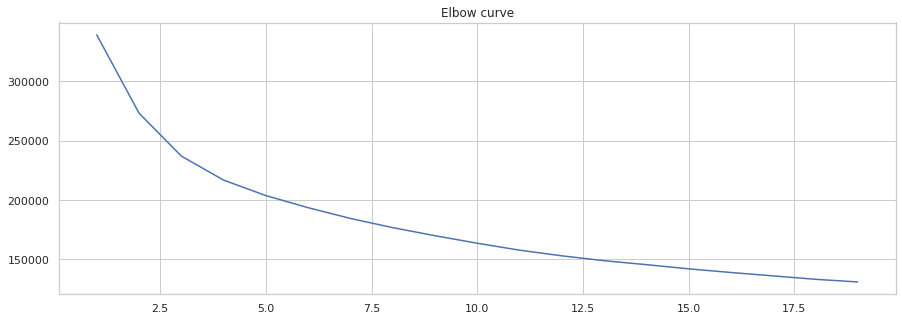

In [ ]:

distorsions = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

The optimal amount of clusters should be at 3 or 4 clusters, according to this graph.

# k-Means

K-means chooses a initial start point for its k centroids. Usually these 'start positions' are representative data points in the distribution. Then for every instance in the dataset the distance to the centroids will me measured. The point gets assigned the neares cluster. After iterating over every data point, the new centroids get calculated out of the mean of their respective cluster.
K-means is guaranteed to converge to a local minimum, which is dependant on the initial location of the centroids. This is a drawbach of this method as its performance is highly veriable on its initialization. There are some methods to mitigate this problem, for example k-fold crossvalidation with different initial locations for the centroids per iteration.

In [ ]:
# function for k cluster algorithms
def k_cluster_df_creator(X , augment_df, algo=KMeans, k=3, rnd_state=0, n_samples=2000, r_seed=3):
  # train and predict model
  cluster_model = algo(n_clusters=k, random_state=rnd_state).fit(X)
  cluster_result = cluster_model.predict(X)
  # check shape
  print(cluster_result.shape)

  # add cluster to sample data for visualization
  cluster_result_df = pd.DataFrame({'cluster': cluster_result})
  cluster_sample = cluster_result_df.sample(n=n_samples, random_state=r_seed).reset_index(drop=True)
  cluster_df = augment_df.join(cluster_sample)

  return cluster_df

## 3 Clusters

In [ ]:
kmeans_df = k_cluster_df_creator(X, augmented_df, k=3)
kmeans_df_2d = k_cluster_df_creator(X, augmented_2d, k=3)

(76133,)
(76133,)


Let's visually inspect this k-Means model by seeing how it mapped the clusters in the embedded feature space:

In [ ]:
fig = px.scatter_3d(kmeans_df, x='x', y='y', z='z', color='cluster') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(kmeans_df_2d, x='x', y='y', color='cluster') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(kmeans_df_2d, x='x', y='y', color='price') # <-- select features for color coding
fig.show()

## 4 Clusters

In [ ]:
kmeans_df = k_cluster_df_creator(X, augmented_df, k=4)
kmeans_df_2d = k_cluster_df_creator(X, augmented_2d, k=4)

(76133,)
(76133,)


In [ ]:
fig = px.scatter_3d(kmeans_df, x='x', y='y', z='z', color='cluster') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(kmeans_df_2d, x='x', y='y', color='cluster') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(kmeans_df_2d, x='x', y='y', color='price') # <-- select features for color coding
fig.show()

## 7 Clusters

In [ ]:
kmeans_df = k_cluster_df_creator(X, augmented_df, k=7)
kmeans_df_2d = k_cluster_df_creator(X, augmented_2d, k=7)

(76133,)
(76133,)


In [ ]:
fig = px.scatter_3d(kmeans_df, x='x', y='y', z='z', color='cluster') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(kmeans_df_2d, x='x', y='y', color='cluster') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(kmeans_df_2d, x='x', y='y', color='price') # <-- select features for color coding
fig.show()

## Conclusion

With k-means the clusters don't perfectly align with data clouds, which is to be expected. As seen in our 3D plot of our t-SNE data, the clusters are not very obvious, even for human eyes. This data point structure might not be perfectly suitable for a simple k-means algorithm.

Another fallback of k-means is that its cluster building is highly dependant the initialization of the centroids. While there are a hand full optimization techniques for initialization, it doesn't change the high veriability of k-means.  

Throughout every k means clustering there was a clustering on the top-left corner of the 2D map, which is where all the high-priced offers reside. This means that one cluster captures a group of cars fearly well, therefore users in such a cluster could be assigned the characteristic 'high priced cars'.

# DBSCAN

DBSCAN is a density based clustering algorithm. Instead of optimizing centroids of a given amount of clusters, clusters are generated based on the density of point clouds. The hyper parameter of DBSCAN is epsilon, which defines the radius around data points on which to generate a cluster.

In [ ]:
# function for dbscan algorithm
def db_cluster_df_creator(X , augment_df, augment_df_2d, eps=0.5, min_samples=5, p=None, n_samples=2000, r_seed=3):
  # train and predict model
  cluster_model = DBSCAN(eps=eps, min_samples=min_samples, p=p).fit(X)
  cluster_result = cluster_model.labels_
  # check shape
  #print(cluster_result.shape)
  print('clusters:\t',len(np.unique(cluster_result)))
  print('outliers:\t', (cluster_result == -1).sum(), '/', len(cluster_result))

  # add cluster to sample data for visualization
  cluster_result_df = pd.DataFrame({'cluster': cluster_result})
  cluster_sample = cluster_result_df.sample(n=n_samples, random_state=r_seed).reset_index(drop=True)

  cluster_df = augment_df.join(cluster_sample)
  cluster_df_2d = augment_df_2d.join(cluster_sample)
  return cluster_df, cluster_df_2d

In [ ]:
dbscan_df, dbscan_df_2d = db_cluster_df_creator(X, augmented_df, augmented_2d, eps=1.0, min_samples=5)

clusters:	 49
outliers:	 691 / 76133


In [ ]:
fig = px.scatter_3d(dbscan_df, x='x', y='y', z='z', color='cluster') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(dbscan_df_2d, x='x', y='y', color='cluster') # <-- select features for color coding
fig.show()

- eps = 0.5, min_samples = 5: 473 individual clusters, 10277 outlier
- eps = 0.5, min_samples = 500: 1 individual clusters, 0 outlier
- eps = 0.5, min_samples = 100: 8 individual clusters, 55566 outlier
- eps = 0.5, min_samples = 250: 5 individual clusters, 71648 outlier
- eps = 0.7, min_samples = 25: 30 individual clusters, 8339 outlier
- eps = 0.7, min_samples = 50: 20 individual clusters, 13368 outlier
- eps = 0.7, min_samples = 80: 17 individual clusters, 18897 outlier
- eps = 0.8, min_samples = 5: 108 individual clusters, 1762 outlier
- eps = 0.8, min_samples = 15: 34 individual clusters, 3930 outlier
- eps = 0.8, min_samples = 50: 19 individual clusters, 8226 outlier
- eps = 0.8, min_samples = 80: 14 individual clusters, 11566 outlier
- eps = 0.9, min_samples = 5: 88 individual clusters, 1082 outlier
- eps = 0.9, min_samples = 25: 22 individual clusters, 3595 outlier
- eps = 0.9, min_samples = 100: 8 individual clusters, 9008 outlier
- eps = 1.2, min_samples = 5: 6 individual clusters, 171 outlier
- eps = 1.2, min_samples = 25: 4 individual clusters, 454 outlier

Values of -1 are considered outliers in DBSCAN. It's interesting to note that Alaska and Hawaii are often considered outliers, propably because of their geographical location.

In general the higher our min_samples is, the more difficult it becomes to find cluster with these amounts of data points at the specified epsilon value. A large min sample tries to find a sizable cluster at the cost of classifying smaller clusters as outliers.

The opposite goes for epsilon. The lower the radius the slimmer the chance of merging into a cluster at the specified min_samples value. The result: A lot of small cluster 'patches' in a large sea of outliers. Epsilon values that are too large tend to conglomorate points into one huge cluster.

## Determining optimal eps and min_select with elbow method

first we'll implement

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

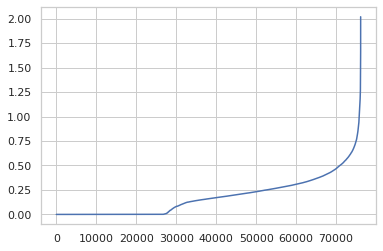

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Optimal eps will be determined by the point of highest curvature ('elbow'), which seems to be at about 0.70.

Next, we'll lock this eps value and figure out the optimal min_samples by trial and error.

**Update**: This method didn't work out as expected and has been discarded. We'll proceed with trial and error.

In [ ]:
dbscan_df, dbscan_df_2d = db_cluster_df_creator(X, augmented_df, augmented_2d, eps=0.90, min_samples=40)

clusters:	 19
outliers:	 4730 / 76133


In [ ]:
fig = px.scatter_3d(dbscan_df, x='x', y='y', z='z', color='cluster', color_continuous_scale=px.colors.sequential.Turbo) # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(dbscan_df_2d, x='x', y='y', color='cluster', color_continuous_scale=px.colors.sequential.deep) # <-- select features for color coding
fig.show()

## Conclusion

Like with k-means it's not easy to find out the optimal hyper-params for DBSCAN, since there are many factors (often even domain specific) that determine the optimal values. Another unique feature about DBSCAN is its classification of outlier values. Since outlier classification isn't a clear cut subject in itself, DBSCAN adds another factor which needs to be taken into account. In our experience the elbow method simplified the decision so much, that it didn't seem to be very useful to us.

One big advantage of DBSCAN over k-means is that it doesn't have a hard boundary that is determined by the centroids. DBSCAN has the ability to conform to complex cluster shapes as long as the cluster parameter (eps & min_sample) allow for it.

After tuning the hyper paramters, DBSCAN became better at identifying actual 'data clouds' than k-means, because of its density based calculation.

The optimal parameters that we determined were **eps = 0.9** and **min_sample = 40**, which in my view was a good trade-off of outliers and cluster count, while not being too one-sided (one dominant cluster).

# Hierarchical Clustering


Hierarchical clustering is our last method that we'll take a look at. It calculates clusters by successively splitting the data into clusters. The top node of builds the top of this hierarchy from which the cluster building propagates down into smaller clusters. This is a top-down approach. Alternatively there is also the buttom-up approach, which we'll apply in this use case, via the **AgglomerativeClustering** class in sklearn.

We'll use the **ward** method for this clustering task. The ward objective function tries to minimize the sum-of-squares difference within each cluster.

In [ ]:
# function for dbscan algorithm
def h_cluster_df_creator(X , augment_df, augment_df_2d, k=3, linkage='ward', affinity='euclidean', n_samples=2000, r_seed=3):

  # We need to take a sample of X, since this clustering method exceeds our RAM capacity
  X = X.sample(n=n_samples, random_state=r_seed).reset_index(drop=True)

  # train and predict model
  cluster_model = AgglomerativeClustering(linkage=linkage, affinity=affinity, n_clusters=k).fit(X)
  cluster_result = cluster_model.fit_predict(X)
  # check shape
  print(cluster_result)

  # add cluster to sample data for visualization
  cluster_result_df = pd.DataFrame({'cluster': cluster_result})
  cluster_sample = cluster_result_df

  cluster_df = augment_df.join(cluster_sample)
  cluster_df_2d = augment_df_2d.join(cluster_sample)
  return cluster_df, cluster_df_2d

In [ ]:
h_df, h_df_2d = h_cluster_df_creator(X, augmented_df, augmented_2d, k=6)
h_df

[2 5 5 ... 2 1 5]


,x,y,z,index,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,cluster
0,0.883973,6.869830,10.571446,4698,montgomery,-0.495659,-1.125,ram,1500,-1.0,0.5,gas,0.747206,clean,automatic,rwd,0.0,pickup,blue,al,-0.955776,0.014837,2
1,-3.577944,5.462449,16.626656,280413,syracuse,-0.040926,-0.500,dodge,grand caravan,-1.0,0.0,gas,-0.385445,clean,automatic,fwd,0.0,mini-van,blue,ny,0.501900,0.420656,5
2,-5.110158,0.611378,-5.018093,107031,orlando,0.247623,0.250,acura,tsx,1.0,-0.5,gas,-0.052401,clean,automatic,fwd,0.0,sedan,grey,fl,-1.472144,0.218258,5
3,8.367016,-5.833988,0.130064,77715,denver,-0.412981,-0.750,chrysler,pt cruiser touring,0.0,-0.5,gas,0.312645,clean,automatic,fwd,-2.0,convertible,custom,co,0.047379,-0.744410,0
4,5.005100,5.800721,12.699526,153361,indianapolis,-0.512195,-0.750,dodge,sprinter 2500,-2.0,-0.5,diesel,1.263163,clean,automatic,rwd,0.0,van,white,in,0.085011,0.018470,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-10.269547,2.422519,-0.824659,230942,asheville,0.909467,0.500,honda,pilot 4wd v6 touring,0.0,0.0,gas,0.064709,clean,automatic,4wd,0.0,SUV,white,nc,-0.566111,0.131602,1
1996,-1.017092,3.332925,14.919740,214699,minneapolis / st paul,-0.413394,-0.750,hyundai,tucson,-1.0,0.0,gas,0.164364,clean,automatic,fwd,0.0,SUV,black,mn,0.819431,-0.257661,5
1997,1.218441,10.178411,2.334753,140000,chicago,0.496486,-1.375,ford,f250 super duty,0.0,1.0,gas,-0.573115,clean,automatic,4wd,0.0,pickup,red,il,0.357187,-0.061423,2
1998,5.203397,-2.421438,-11.082944,351296,sioux falls / SE SD,-0.040926,-0.375,toyota,prius hybrid,0.0,-0.5,gas,-0.397966,clean,automatic,fwd,-1.0,hatchback,silver,sd,0.581043,-0.411706,1


In [ ]:
#color_continuous_scale=px.colors.sequential.Turbo
fig = px.scatter_3d(h_df, x='x', y='y', z='z', color='cluster') # <-- select features for color coding
fig.show()

In [ ]:
fig = px.scatter(h_df_2d, x='x', y='y', color='cluster') # <-- select features for color coding
fig.show()

## Conclusion

Hierarchical clustering seems to be a very memory hungry operation, which quickly exeeded colab RAM limits within seconds. Therefore we worked on a small sample on the dataset. It isn't clear how it impacted this clustering in comparison to the other two methods, which used the entire dataset.

# Conclusion

We decided to only use feature embedding to have a visual look at the data. This means that every clustering algorithm has been performed on its real feature space and then translated to its embedded space. Another approach would be to run the clustering algorithms on the embedded space itself.

Overall, each clustering Method required a completly different approach to optimization and parameter tuning. Their algorithmic differences also reflect in their cluster outputs. There seem to be some similarities between k-means, DBSCAN and AgglomorativeClustering, like for example a cluster on the upper-left edge on the dataset.

These different outcomes make it hard to assess what 'the wrong or right' cluster is, especially with a real world dataset that doesn't have clear-cut clusters. There are some tools that help elvaluate the clusters like the shilhuette analysis, but they are by no means as unequivocal as a precision or recall metric in classification for example. The only way to find out is to select and analyize the individual cluster outputs of each method and evaluate which clusters have the most insightful and concise segmentation that can be translated to business value adding measures, like targeted marketing campaigns.